In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.definitions import ROOT_DIR
from src.data.utils import download_from_groningen, head, line_count
from src.data.quality import check_grid_spacing
from src.visualization.visualize import plot_cartesian_gridded_surface

# The Groningen field

In this section, we present some of the relevant and interesting facts of the Groningen gas field, extracted from the field's geologic overview by de Jager and Visser (2017). The Groningen field data is vast, but we can use this information to find the files needed for our study. 

The Groningen gas field was discovered in 1959 by the Slochteren-1 well. This well primary target was to test the gas trend in the Basal Zechstein carbonates, which resulted in tight basinal facies. However, the underlying Rotliegend sandstones unexpectedly found a large volume of gas. The initial recoverable gas reserves are estimated at 2900 bcm (~100 TCF). Additional field information is summarized in table 1.

Table 1: Groningen field summary.

|               | Description |
| ------------- | ----------- |
| **Structure** | Faulted anticline (4-way). The closure formed during the late Triassic or Jurassic. The primary faults have normal displacement and trend NNW–SSE. Secondary fault trends run E-W and N-S. |
| **Seal** | The top seal consists of carbonates and anhydrites layers from the Zechstein Formation. Laterally, the gas accumulation is mainly constrained by faults. |
| **Source** | Main source rocks (Carboniferous age) are the underlying and juxtaposed Westphalian Coal Measures and the basal Namurian organic shales. The primary expulsion event occurred during the Late Jurassic - Early Cretaceous. |
| **Reservoir** | Upper Permian Rotliegend reworked aeolian and fluvial sediments. High degree of sorting. Porosity ranges from 10-24 %, and permiability from 1-1000 mD. Three facies: Sandstones, conglomerates, and mudstones. |
| **FWL** | Changes by fault block, from 2972-3016 m TVNAP (NAM, 2016).|


# The Groningen data

In 2020, Nederlandse Aardolie Maatschappij (NAM) released the Groningen gas field geological model throught the Utrecht University data publication platform under a CC BY 4.0 license. These data consists of well logs, seismic horizons, a PSDM seismic cube, and the field's geocellular model, all embedded in a Petrel project. In the same year, Data Underground (2020) forked NAM's project, and made most of its data accessible in common sharing formats (CSV, LAS, SEGY, etc.). In this work, we access the data in the Data Underground repository.

The first step in our workflow is to download the data that we will use to recreate the seismic uncertainty analysis (SUA) surfaces. The typical result of a SUA is a set of P10-P50-P90 values that describe the in-place rock volume distribution of a reservoir, based on multiple iterations of the target's structural top which are derived from equiprobable imaging velocity models.

In our case, we are interested in creating multiple iterations of the reservoir structural top, so we should be looking for horizons and well tops that correspond to the Rotliegend, in addition to any other information (images, reports, README files) that will help us understand the data. 


# Data download

The data files are hosted on an Amazon's S3 bucket and can be downloaded by requesting a URL with the base repository location plus a given file name. The base repository location is

`https://swung-hosted.s3.ca-central-1.amazonaws.com/`

By reading the [Data Underground](https://dataunderground.org/dataset/groningen-open-fork) fork we find that there is a file named `groningen/README.txt`. Let's download and read this file to inform our selection of files to download.

For convenience, we added the function `download_from_groningen`, that does the URL building and requesting for us. Let's use it to dowload the README file.

In [5]:
files_to_download = ["groningen/README.txt"]

# Local place to save the downloaded files
dst_dir = ROOT_DIR / "data/external/"

In [10]:
head(dst_dir / "groningen/README.txt", max_line_count=30)

3D Grid: 
- Exported 3D grid (a.k.a reservoir model) of the Groningen field AOI in Eclipse grid and properties format (ASCII). 
- The export settings for 3D grid export settings and view of the horizon order are saved as PNG files.

Cultural data: 

-ESRI shapefile exports of boundary polygons of the country of NL, Fields, Reservoirs, Discoveries and concession blocks. 
Please note that easting and northings are based on this CRS: ED50_TM5NE_1311_23059

Seismic_Interpretation: 
- Overburden and top reservoir horizon interpretation.
- NS_B: Base North Sea
- CK_B: Base Chalk (Base Upper Cretaceous) 
- RNRO1_T: Top Rot Halite (Just above base of Upper Triassic) in Time and depth
- ZE_T: Top Zechstein (Permian)
- RO_T: Top Rotliegend (Permian)

Seismic_volume: 
- SEGY export from the bricked ZGY file that was supplied with the Petrel project.

Fault_Model: 
- Fault pillar in Petrel ASCII format (Note: this are the grid pillars that were built as input for 3D grid building, they are not in 

Excellent! Based on the README file, we know that the target sesimic horizon (Top Rotliegend) name is `RO_T`. To complement this information, let's download the file `groningen/FILENAMES.txt`, that lists the names of the files stored in the data repository. We can use this file name list to select the files to download.


In [11]:
# List with the file names to download
files_to_download = ["groningen/FILENAMES.txt"]

In [12]:
download_from_groningen(files_to_download, dst_dir, overwrite=False)

Will not overwrite file: groningen/FILENAMES.txt


If all ran without errors, there should be a new file under `<project_dir>/groningen/FILENAMES.txt`.

We can open this text file to explore all of its content, looking for data useful to our study, that is, the top reservoir surface, well tops, and any pictures.

In [33]:
files_to_download = [
    "groningen/README.txt",
    "groningen/FILENAMES.txt",
    "groningen/Horizon_Interpretation/RO____T",
    "groningen/Horizon_Interpretation/RO____T.crsmeta.xml",
    "groningen/Formation_tops/Groningen__Formation_tops__EPSG_28992.csv",
    "groningen/3DGrid/3D_Grid_Export_settings.PNG",
    "groningen/3DGrid/3D_Grid_Horizon_order.png",
]

In [34]:
download_from_groningen(files_to_download, dst_dir, overwrite=False)

Will not overwrite file: groningen/README.txt
Will not overwrite file: groningen/FILENAMES.txt
Will not overwrite file: groningen/Horizon_Interpretation/RO____T
Will not overwrite file: groningen/Horizon_Interpretation/RO____T.crsmeta.xml
Will not overwrite file: groningen/Formation_tops/Groningen__Formation_tops__EPSG_28992.csv
Will not overwrite file: groningen/Formation_tops/Well_Tops.asc
Will not overwrite file: groningen/3DGrid/3D_Grid_Export_settings.PNG
Will not overwrite file: groningen/3DGrid/3D_Grid_Horizon_order.png


# Data exploration

Let's first look at the downloaded pictures:

Figure 1: Static model horizon order (NAM, 2020).

<img src="figures/3D_Grid_Horizon_order.png"  alt="Static model horizon order" width="30%" height="30%" title="Static model horizon order">


Figure 2: 3D grid export settings (NAM, 2020).

<img src="figures/3D_Grid_Export_settings.PNG"  alt="3D grid export settings" width="30%" height="30%" title="3D grid export settings">

From figure 1 and 2, we learn that the top of the reservoir model corresponds to the Top Rotliegend horizon, and that the simulation grid is not rotated, so possibly the horizon grids are also not rotated.

## Top Rotliegend

Before we start working with the Top Rotliegend horizon, we need to ensure that we can load it correctly. For this purpose, we will use the Top Rotliegend map in Kortekaas and Jaarsma (2017) as the reference (figure 3). 

Figure 3: Top Rotliegend reference map (Kortekaas and Jaarsma, 2017).

<img src="figures/Top_Rotliegend_2017_Kortekaas_Jaarsma.jpeg"  alt="Reference Top Rotliegend" width="50%" height="50%" title="Reference Top Rotliegend">

What a pretty map! Now our goal is to recreate this map from the downloaded horizon. First, lets look at the file `RO____T` file.

In [15]:
interp_RO_T_path = dst_dir / files_to_download[2]

line_count(interp_RO_T_path)

Line count: 671,204


That is a lot of lines! Let's check the first few lines.

In [16]:
head(interp_RO_T_path)

                          7890      9177   227262.50   604437.50    2956.828    
                          7890      9179   227262.50   604487.50    2957.884    
                          7892      9162   227312.50   604062.50    2962.655    
                          7892      9164   227312.50   604112.50    2960.826    
                          7892      9166   227312.50   604162.50    2960.254    
                          7892      9168   227312.50   604212.50    2960.195    
                          7892      9171   227312.50   604287.50    2960.726    
                          7892      9173   227312.50   604337.50    2962.112    
                          7892      9175   227312.50   604387.50    2963.912    
                          7892      9177   227312.50   604437.50    2965.196    


OK, there is no header, but the data is tabular, space separated, and the columns seem to be: Inline, Crossline, Easting, Northing, and Depth. Let's use this observations to load the data into a Pandas dataframe.

In [17]:
col_names = ["inline", "xline", "easting", "northing", "depth"]
ro_t = pd.read_csv(interp_RO_T_path, sep=r"\s+", header=None, names=col_names)

In [18]:
ro_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671204 entries, 0 to 671203
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   inline    671204 non-null  int64  
 1   xline     671204 non-null  int64  
 2   easting   671204 non-null  float64
 3   northing  671204 non-null  float64
 4   depth     671204 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 25.6 MB


Typically, seismic horizons are created and exported in a regular grid, i.e. the seismic grid. Let's check the grid dimensions.

In [19]:
unique_northing = check_grid_spacing(ro_t.northing)

           Count
Grid size       
50.0         956
75.0          24


What!? So most grid northing lenght is 50 m, but there are a few grid rows with 75 m length. Weird. Let's repeat the exercise for the easting direction.

In [22]:
unique_easting = check_grid_spacing(ro_t.easting)

           Count
Grid size       
50.0         808
75.0          28


Again, most grid easting columns size are 50 m, but a few have 75 m in lenght. Let's see where these odd sized grid rows and columns post in a map.

In [23]:
unique_northing_diff_mask = np.diff(unique_northing) != 50

unique_northing_off_values =  unique_northing[:-1][unique_northing_diff_mask]

In [24]:
unique_easting_diff_mask = np.diff(unique_easting) != 50
unique_easting_off_values =  unique_easting[:-1][unique_easting_diff_mask]

In [25]:
vmin = ro_t.northing.min()
vmax = ro_t.northing.max()
xmin = ro_t.easting.min()
xmax = ro_t.easting.max()

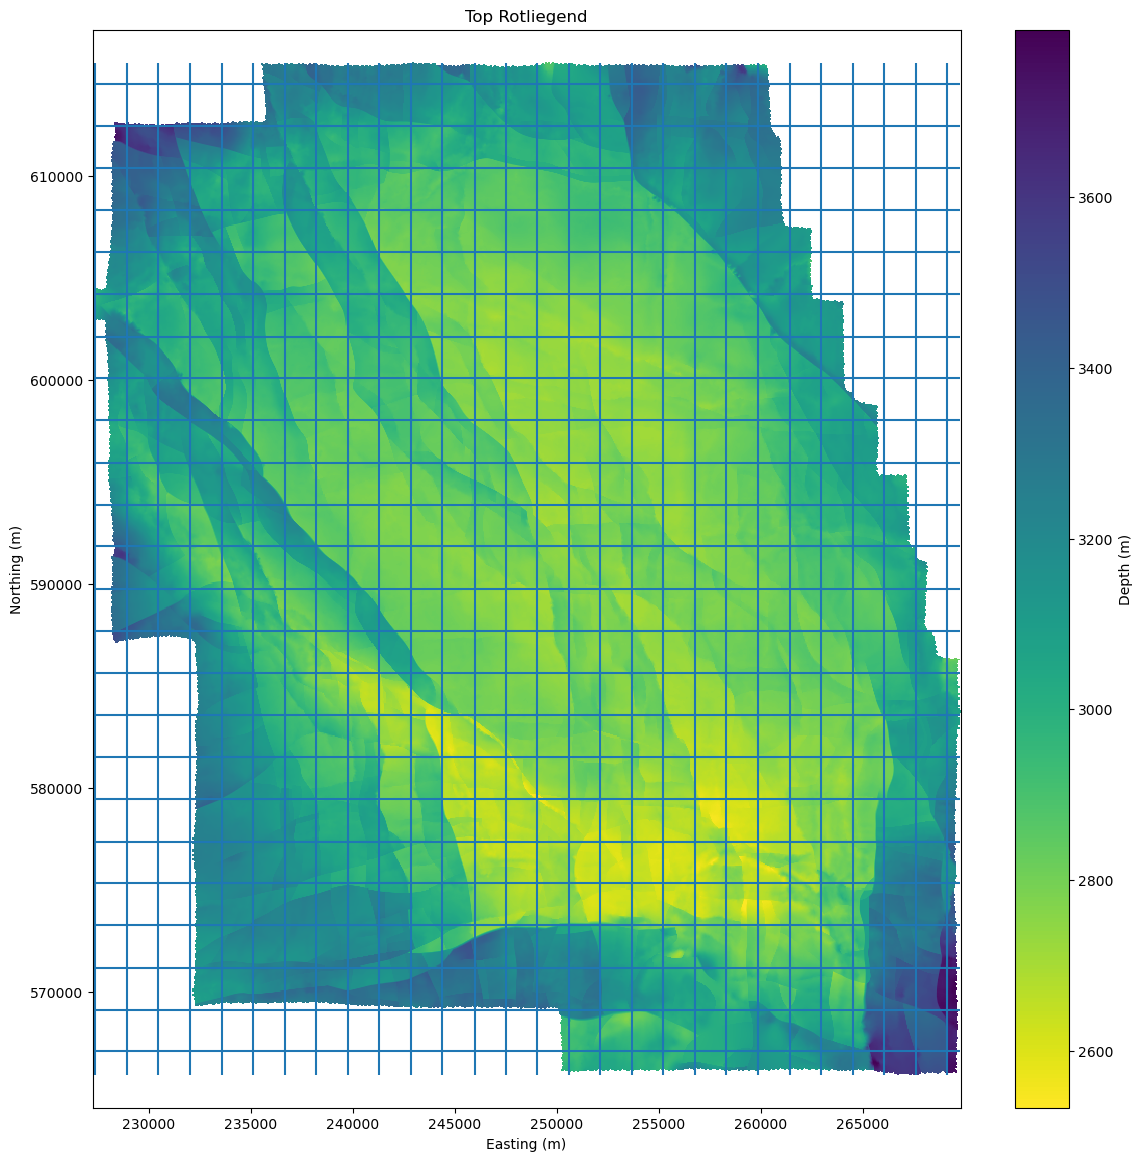

In [28]:
title = "Top Rotliegend"
fig, ax = plot_cartesian_gridded_surface(ro_t, title=title, figsize=(14,14))
ax.hlines(unique_northing_off_values,xmin=xmin, xmax=xmax)
ax.vlines(unique_easting_off_values, ymin=vmin, ymax=vmax)
plt.show()

Well, the good news is that we can create a map similar to the reference Top Rotliegend presented in Kortekaas and Jaarsma (2017).


<img src="figures/Top_Rotliegend_2017_Kortekaas_Jaarsma.jpeg"  alt="Reference Top Rotliegend" width="35%" height="35%" title="Reference Top Rotliegend">

<img src="figures/Loaded_Top_RO.png"  alt="Loaded Top Rotliegend" width="53%" height="53%" title="Loaded Top Rotliegend">